In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv("./GeneratedLabelledFlows/TrafficLabelling/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df.drop(["Flow ID", " Source IP", " Source Port", " Destination IP", " Destination Port", " Protocol", " Timestamp"], axis=1, inplace=True)

In [3]:
df.isnull().sum()

 Flow Duration                  0
 Total Fwd Packets              0
 Total Backward Packets         0
Total Length of Fwd Packets     0
 Total Length of Bwd Packets    0
                               ..
Idle Mean                       0
 Idle Std                       0
 Idle Max                       0
 Idle Min                       0
 Label                          0
Length: 78, dtype: int64

In [4]:
df.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3,2,0,12,0,6,6,6.0,0.0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,109,1,1,6,6,6,6,6.0,0.0,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,52,1,1,6,6,6,6,6.0,0.0,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,34,1,1,6,6,6,6,6.0,0.0,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,3,2,0,12,0,6,6,6.0,0.0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
X = df.drop(" Label", axis=1)
y = df[" Label"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((151249, 77), (151249,), (74496, 77), (74496,))

In [8]:
from sklearn.discriminant_analysis import StandardScaler

if np.any(np.isinf(X_train)) or np.any(np.isinf(X_test)):
    print("Infinity values found in the dataset.")
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

if np.any(np.isnan(X_train)) or np.any(np.isnan(X_test)):
    print("NaN values found in the dataset.")
    X_train.fillna(X_train.mean(), inplace=True)
    X_test.fillna(X_test.mean(), inplace=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# X_train_scaled = X_train_scaled[:10000]
# y_train = y_train.iloc[:10000]

Infinity values found in the dataset.
NaN values found in the dataset.


In [9]:
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape

((151249, 77), (74496, 77), (151249,), (74496,))

In [10]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     32269
        DDoS       1.00      1.00      1.00     42227

    accuracy                           1.00     74496
   macro avg       1.00      1.00      1.00     74496
weighted avg       1.00      1.00      1.00     74496

0.9981341280068728


In [11]:
random_state = 42
classifier = [DecisionTreeClassifier(random_state = random_state),
             SVC(random_state = random_state),
             RandomForestClassifier(random_state = random_state),
             LogisticRegression(random_state = random_state),
             KNeighborsClassifier()]

dt_param_grid = {"min_samples_split" : range(10,500,20),
                "max_depth": range(1,20,2)}

svc_param_grid = {"kernel" : ["rbf"],
                 "gamma": [0.001, 0.01, 0.1, 1],
                 "C": [1,10,50,100,200,300,1000]}

rf_param_grid = {"max_features": [1,3,10],
                "min_samples_split":[2,3,10],
                "min_samples_leaf":[1,3,10],
                "bootstrap":[False],
                "n_estimators":[100,300],
                "criterion":["gini"]}

logreg_param_grid = {"C":np.logspace(-3,3,7),
                    "penalty": ["l2"]}

knn_param_grid = {"n_neighbors": np.linspace(1,19,10, dtype = int).tolist(),
                 "weights": ["uniform","distance"],
                 "metric":["euclidean","manhattan"]}
classifier_param = [dt_param_grid,
                   svc_param_grid,
                   rf_param_grid,
                   logreg_param_grid,
                   knn_param_grid]
cv_result = []
best_estimators = []

In [12]:
cv_result = []
best_estimators = []
for i in range(len(classifier)):
    clf = GridSearchCV(classifier[i], param_grid=classifier_param[i], cv = StratifiedKFold(n_splits = 10), scoring = "accuracy", n_jobs = -1,verbose = 1)
    clf.fit(X_train_scaled,y_train)
    cv_result.append(clf.best_score_)
    best_estimators.append(clf.best_estimator_)
    print(cv_result[i])

Fitting 10 folds for each of 250 candidates, totalling 2500 fits
0.9996958660199649
Fitting 10 folds for each of 28 candidates, totalling 280 fits
0.9995834688885926
Fitting 10 folds for each of 54 candidates, totalling 540 fits
0.9998413214397346
Fitting 10 folds for each of 7 candidates, totalling 70 fits


c:\Users\ankus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9989223096780115
Fitting 10 folds for each of 40 candidates, totalling 400 fits


c:\Users\ankus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [0.99946446 0.99946446 0.99940496 0.99944463 0.99937851 0.99946446
 0.99938512 0.99945124 0.99933884 0.99947107 0.99933884 0.99947107
 0.99923967 0.99944462 0.9992     0.99945785 0.9991471  0.99945785
 0.99916033 0.99945124        nan 0.9995438         nan 0.9995438
        nan 0.99952396        nan 0.99948429        nan 0.99952396
        nan 0.99951735        nan 0.99950413        nan 0.99950413
        nan 0.99951074        nan 0.99949091]
  warnings.warn(


0.9995437999042626


Text(0.5, 1.0, 'Cross Validation Scores')

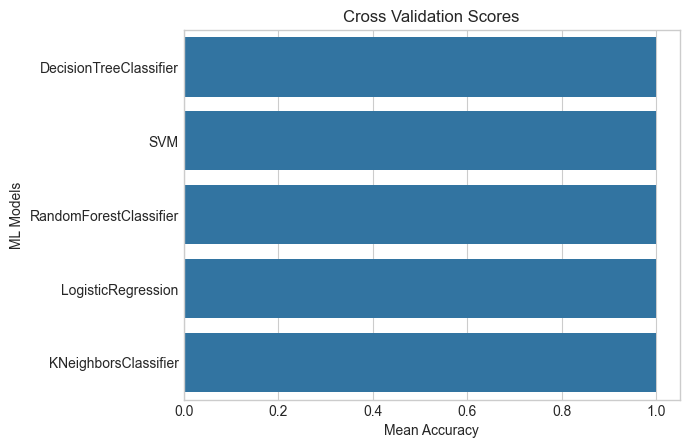

In [13]:
cv_results = pd.DataFrame({"Cross Validation Means":cv_result, "ML Models":["DecisionTreeClassifier", "SVM","RandomForestClassifier",
       "LogisticRegression",
       "KNeighborsClassifier"]})

g = sns.barplot(x="Cross Validation Means",y= "ML Models", data=cv_results)
g.set_xlabel("Mean Accuracy")
g.set_title("Cross Validation Scores")

In [14]:
votingC = VotingClassifier(estimators = [("dt",best_estimators[0]),
                                        ("rfc",best_estimators[2]),
                                        ("knn",best_estimators[4])],
                                        voting = "soft", n_jobs = -1)
votingC = votingC.fit(X_train_scaled, y_train)

print("Accuracy Score: ",accuracy_score(votingC.predict(X_test_scaled), y_test))

Accuracy Score:  0.9998254939862543


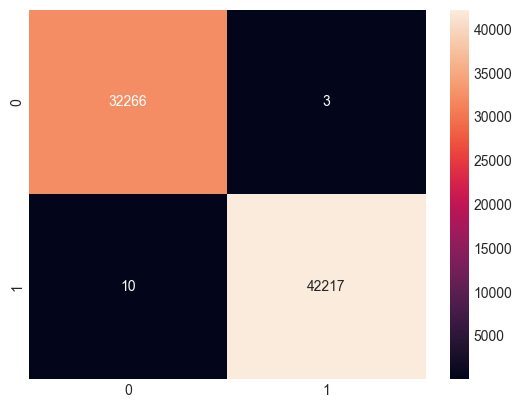

In [15]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, votingC.predict(X_test_scaled))
sns.heatmap(cm, annot=True, fmt="d")
plt.savefig("ConfusionMatrix.png")
plt.show()

In [16]:
df = pd.DataFrame(y_test)
df["Predicted Label"] = votingC.predict(X_test_scaled) 
df = df.sort_index(axis=0)
df.columns = ["Actual Label", "Predicted Label"]
df.to_csv("PredictedLabels.csv")

In [17]:
import pickle
try:
    with open("./DDoS_Detection_Model/DDoS_Detection_Model_07_Jun_2024.pkl", "wb") as ddos_model_file_07_Jun_2024:
        pickle.dump(votingC, ddos_model_file_07_Jun_2024)
    print("Model saved successfully.")
except PermissionError as e:
    print(f"Permission error occurred while saving the model: {e}")
except Exception as e:
    print(f"An error occurred while saving the model: {e}")

try:
    with open("./DDoS_Detection_Model/DDoS_Detection_Model_07_Jun_2024.pkl", "rb") as ddos_model_file_07_Jun_2024:
        model = pickle.load(ddos_model_file_07_Jun_2024)
    print("Model loaded successfully.")
except PermissionError as e:
    print(f"Permission error occurred while loading the model: {e}")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")

Model saved successfully.
Model loaded successfully.


In [18]:
print("Accuracy Score: ",accuracy_score(model.predict(X_test_scaled), y_test))

Accuracy Score:  0.9998254939862543
